Task 2
=======

Consider the mutual information, see expression (2) in _Neuman et al.’2003_ paper, as a guideline to derive the metaphor-reasoning.  You may help with other available implementations of mutual information, in [Collocations (nltk.org)](https://www.nltk.org/howto/collocations.html), [FNLP 2011: Tutorial 8: Working with corpora: mutual information (ed.ac.uk)](http://www.inf.ed.ac.uk/teaching/courses/fnlp/lectures/8/tutorial.html). Consider the words “man”, “sky”, “life”, “love”, “hate”. Write a program that identifies all adjectives, adverbs and verbs that occur within 3 lexical units (span = 3 in the formula of mutual information) in British national corpus and whose mutual information is equal or greater than 3, considered as the minimum statistical significance.

Run time estimates written in comments are run with Ryzen 5 5600X, and may take longer with slower computers, for example laptops.

In [124]:
import nltk
import math
from nltk.corpus.reader.bnc import BNCCorpusReader
from nltk import FreqDist
import matplotlib.pyplot as plt

In [125]:
#Data structure for storing info of a collocate word
class CollocateWord:
    
    def __init__(self, collocate):
        self.collocate = collocate
        #Frequency of how often collocate word is found with word of interest
        self.collocateFrequency = 1
        #Will be calculated later with method call
        self.mutualInformation = None
        #Words count in corpus. Will be set later with method call
        self.corpusFrequency = None
        #Is the word positioned before of after the parent word in a sentence
        self.position = None #Not used yet

    def getWord(self):
        return self.collocate

    #Called in main each time the same word is found again
    def updateFrequency(self):
        self.collocateFrequency += 1

    def printMe(self):
        print("Collocate word: " + self.collocate)
        print("Frequency with parent word: " + str(self.collocateFrequency))
        print("Frequency in corpus: " + str(self.corpusFrequency))
        print("MI score: " + str(self.mutualInformation))

    def setMutualInformation(self, MI):
        self.mutualInformation = MI

    def setCorpusFrequency(self, freq):
        self.corpusFrequency = freq

In [126]:
#Data structure and logic for word under search and its collocates
class MutualInformationCalculator:
    
    def __init__(self, word, corpusSentences, corpusWords, span, sizeOfCorpus, freqDistribution):
        self.word = word
        self.frequency = 0
        self.collocates = []
        self.corpusSentences = corpusSentences
        self.corpusWords = corpusWords
        self.span = span
        self.sizeOfCorpus = sizeOfCorpus
        self.freqDistribution = freqDistribution

    def findCollocates(self):
        '''Find all collocate words around the word of interest'''    
        for sentence in self.corpusSentences:
            l_sentence = [(word_tuple[0].lower(), word_tuple[1] )for word_tuple in sentence]
            #if(l_sentence[0].count(self.word) == 0):
            #    continue
            #Should we remove stop words from search? Should be done here, at latest.
            for index, word in enumerate(l_sentence):
                #print(word[0].lower())
                #print(index)
                if word[0] == self.word:
                    self.updateFrequency()
                    self.findSpanningCollocations(l_sentence, index)
    
    def findSpanningCollocations(self, sentence, startingIndex,):
        '''When words of interest is found in the sentence, the sentence and index is passed here to find collocate words
        and updateCollocates is called for valid words to save them'''
        listOfIndexes = []
        #Assuming that the span = 3 in the task description actually means windows size instead, check only adjacent indexes.
        #  CURRENTLY FIXED WINDOW SIZE = 3
        indexesToTry = [startingIndex - 1, startingIndex + 1]
        for index in indexesToTry:
            if index >= 0 and index < len(sentence):
                word, wordType = sentence[index]
                #program should indentify only adjectives, adverbs and verbs
                if wordType == 'ADJ' or wordType == 'ADV' or wordType == "VERB":
                    self.updateCollocates(word)

    def updateCollocates(self, collocateWord):
        '''Checks if collocate is new to append it to list or to just update existing frequency'''
        #Check if collocate list is empty
        if self.collocates:
            for collocate in self.collocates:
                if collocate.getWord() == collocateWord:
                    collocate.updateFrequency()
                    return
                    
            self.collocates.append(CollocateWord(collocateWord))
        else:
            self.collocates.append(CollocateWord(collocateWord))
    
    #Used while searching collocate words.
    def updateFrequency(self):
        self.frequency += 1

    def calculateCollocateFrequencies(self):
        #Set the frequency in corpus for every collocate word
        for collocate in self.collocates:
            collocate.setCorpusFrequency(self.freqDistribution[collocate.getWord()])
            

    def printMe(self):
        print("Word of interest: " + self.word)
        print("Frequncy in corpus: " + str(self.frequency))
        print("Collocate words found: " + str(len(self.collocates)))

    def printCollocates(self):
        for collocate in self.collocates:
            collocate.printMe()

    def getCollocates(self):
        return self.collocates

    def calculateMutualInformations(self):
        '''Calculate MI for all collocate words. Requires that frequencies are calculated before running this.'''
        for collocate in self.collocates:
            MI = math.log10(( (collocate.collocateFrequency * self.sizeOfCorpus) / (self.frequency * collocate.corpusFrequency * self.span) ))
            MI = MI / math.log10(2)
            collocate.setMutualInformation(MI)

    def calculateAll(self):
        '''Does all calculation steps in one command.'''
        self.findCollocates()
        self.calculateCollocateFrequencies()
        self.calculateMutualInformations()
        self.removeCollocatesBelowFrequency(2)
        self.removeCollocatesBelowMI(3)

    def getCollacatesOverMiValue(self, limit):
        '''Return a list of collocates above wanted MI value'''
        return [collocate for collocate in self.collocates if (collocate.mutualInformation >= limit)]

    def getCollocatesOverFrequency(self, limit):
        return [collocate for collocate in self.collocates if (collocate.collocateFrequency >= limit)]

    def removeCollocatesBelowFrequency(self, limitFrequency):
        '''Remove collocates from object whose frequency with word of interest is lower than given limit.'''
        self.collocates[:] = [collocate for collocate in self.collocates if (collocate.collocateFrequency >= limitFrequency)]

    def removeCollocatesBelowMI(self, limitMI):
        self.collocates[:] = [collocate for collocate in self.collocates if (collocate.mutualInformation >= limitMI)]

    def sortCollocatesByFrequency(self):
        self.collocates.sort(key=lambda collocate: collocate.collocateFrequency, reverse=True)

    def sortCollocatesByMIscore(self):
        self.collocates.sort(key=lambda collocate: collocate.mutualInformation, reverse=True)

    def plotFrequencyFigure(self, xSize, ySize):
        miLim = 3
        fLim = 2
        self.sortCollocatesByFrequency()
        words = [c.collocate for c in self.collocates]
        freqs = [c.collocateFrequency for c in self.collocates]
        fig, ax = plt.subplots(figsize = (xSize, ySize))
        ax.set_ylabel('Mutual frequency', fontsize=15)
        ax.set_title('Frequency of adjacent words from \'' + self.word + '\' with MI score >= ' + str(miLim) + ' and mutual frequency >= ' + str(fLim) + ')')
        ax.barh(words, freqs)
        plt.show()

    def plotMiFigure(self, xSize, ySize):
        miLim = 3
        fLim = 2
        self.sortCollocatesByMIscore()
        words = [c.collocate for c in self.collocates]
        mi_score = [c.mutualInformation for c in self.collocates]
        fig, ax = plt.subplots(figsize = (xSize, ySize))
        ax.set_ylabel('Mutual Information score', fontsize=15)
        ax.set_title('Mutual information score over ' + str(miLim) + ' with a word \'' + self.word + '\' and mutual frequency >= ' + str(fLim) + ')')
        ax.barh(words, mi_score)
        plt.show()

    

In [127]:
#Read the British National Corpus from folder BNC/Texts. This need to be downloaded and exctracted separately from internet.
reader = BNCCorpusReader(root='BNC/Texts/', fileids=r'[A]/\w*/\w*\.xml')
#We want to stay in the context of one sentence when discovering mutual information (and methaphores), so we will read sentences from the corpus.
#For some reason, the senctences include only 15 million words of the total 100 million.
sentences = reader.tagged_sents()
#Defining the span (windows size) of the search
#Currently this needs to be fixed to 3
span = 3

In [128]:
#Run time ~4 min

#We'll also read words for calculating frequency of all words in the corpus (+ size of corpus)
words = reader.words()
#We want decapitalize words for easier handling
lower_words = [word.lower() for word in words]
sizeOfCorpus = len(lower_words)

In [129]:
#Calculate frequencies for all the words in corpus
fdist = FreqDist(lower_words)

To show example and see run time, we run all steps for word 'man' separately.

In [130]:
#Creating the calculator object
man = MutualInformationCalculator('man', sentences, lower_words, span, sizeOfCorpus, fdist)


In [131]:
#Run time ~2 min 
man.findCollocates()

In [132]:
man.calculateCollocateFrequencies()

In [133]:
man.calculateMutualInformations()

In [134]:
man.printMe()

Word of interest: man
Frequncy in corpus: 8897
Collocate words found: 1612


In [135]:
#We cannot make too strong conclusions from words with low frequency with the word of interest.
man.removeCollocatesBelowFrequency(2)
#Task defined minimum mutual information of 3 to be found
man.removeCollocatesBelowMI(3)
man.printMe()

Word of interest: man
Frequncy in corpus: 8897
Collocate words found: 139


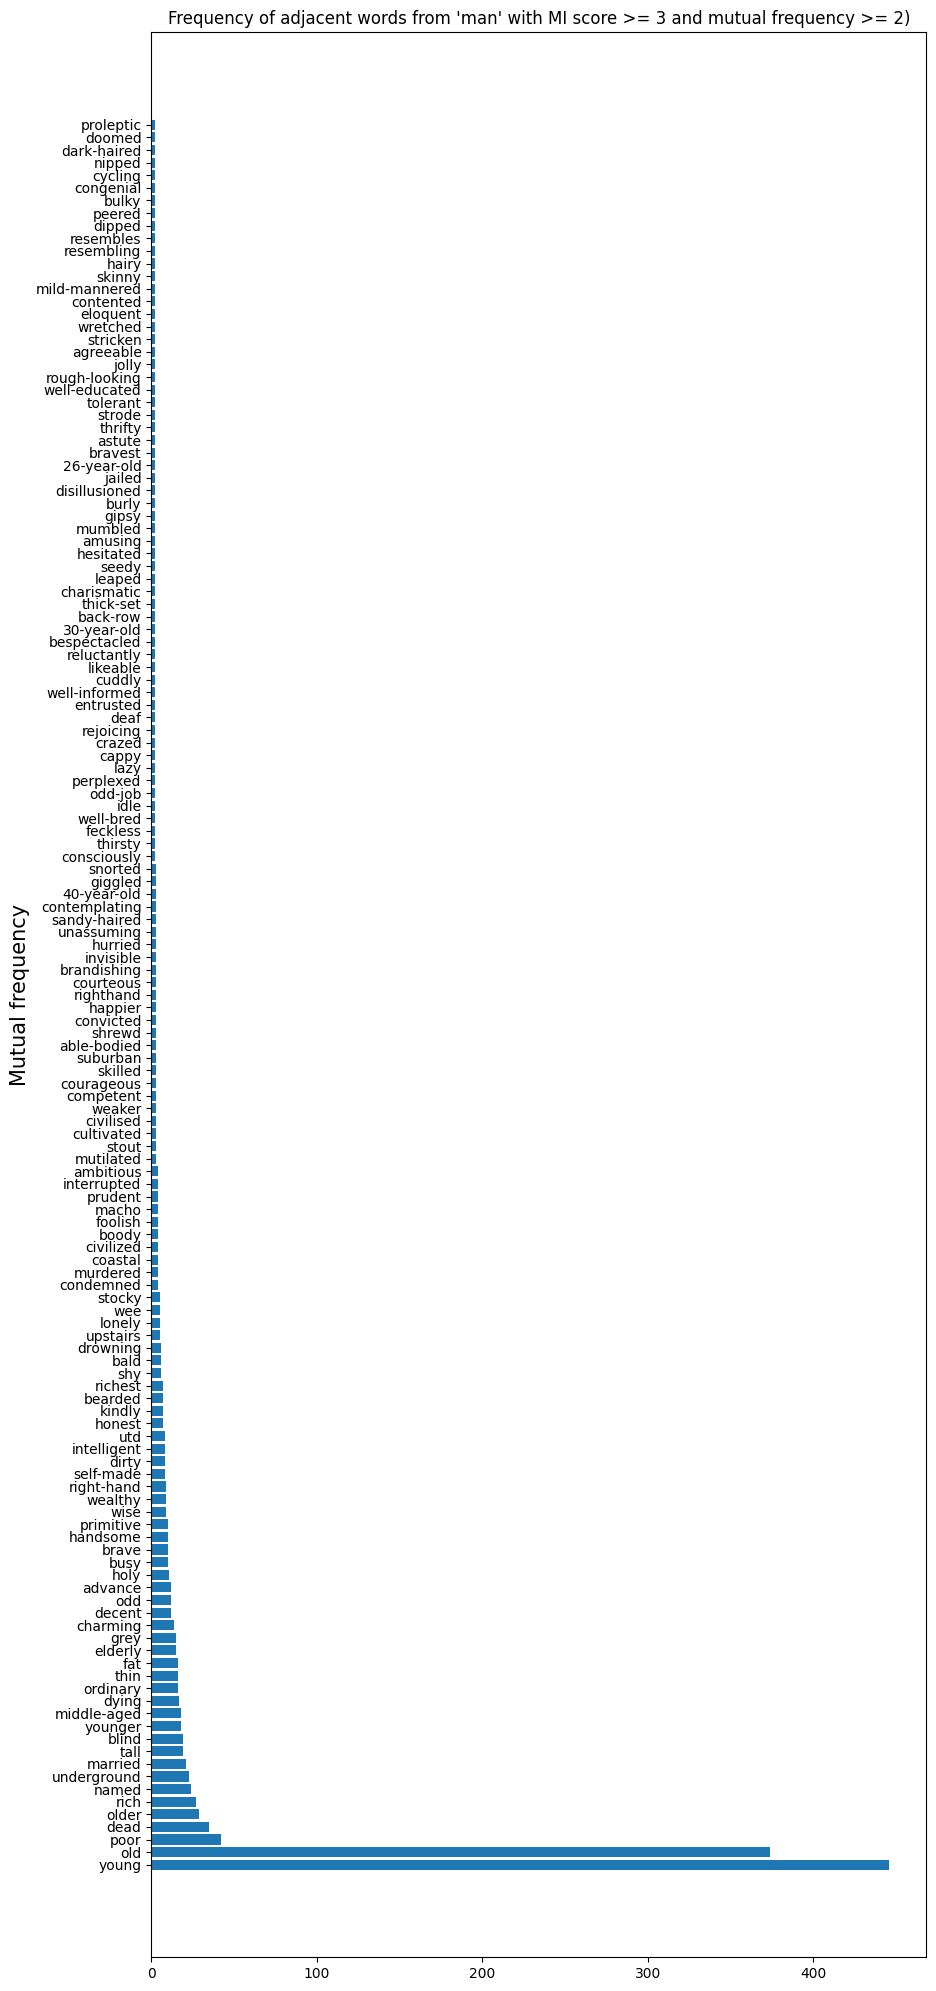

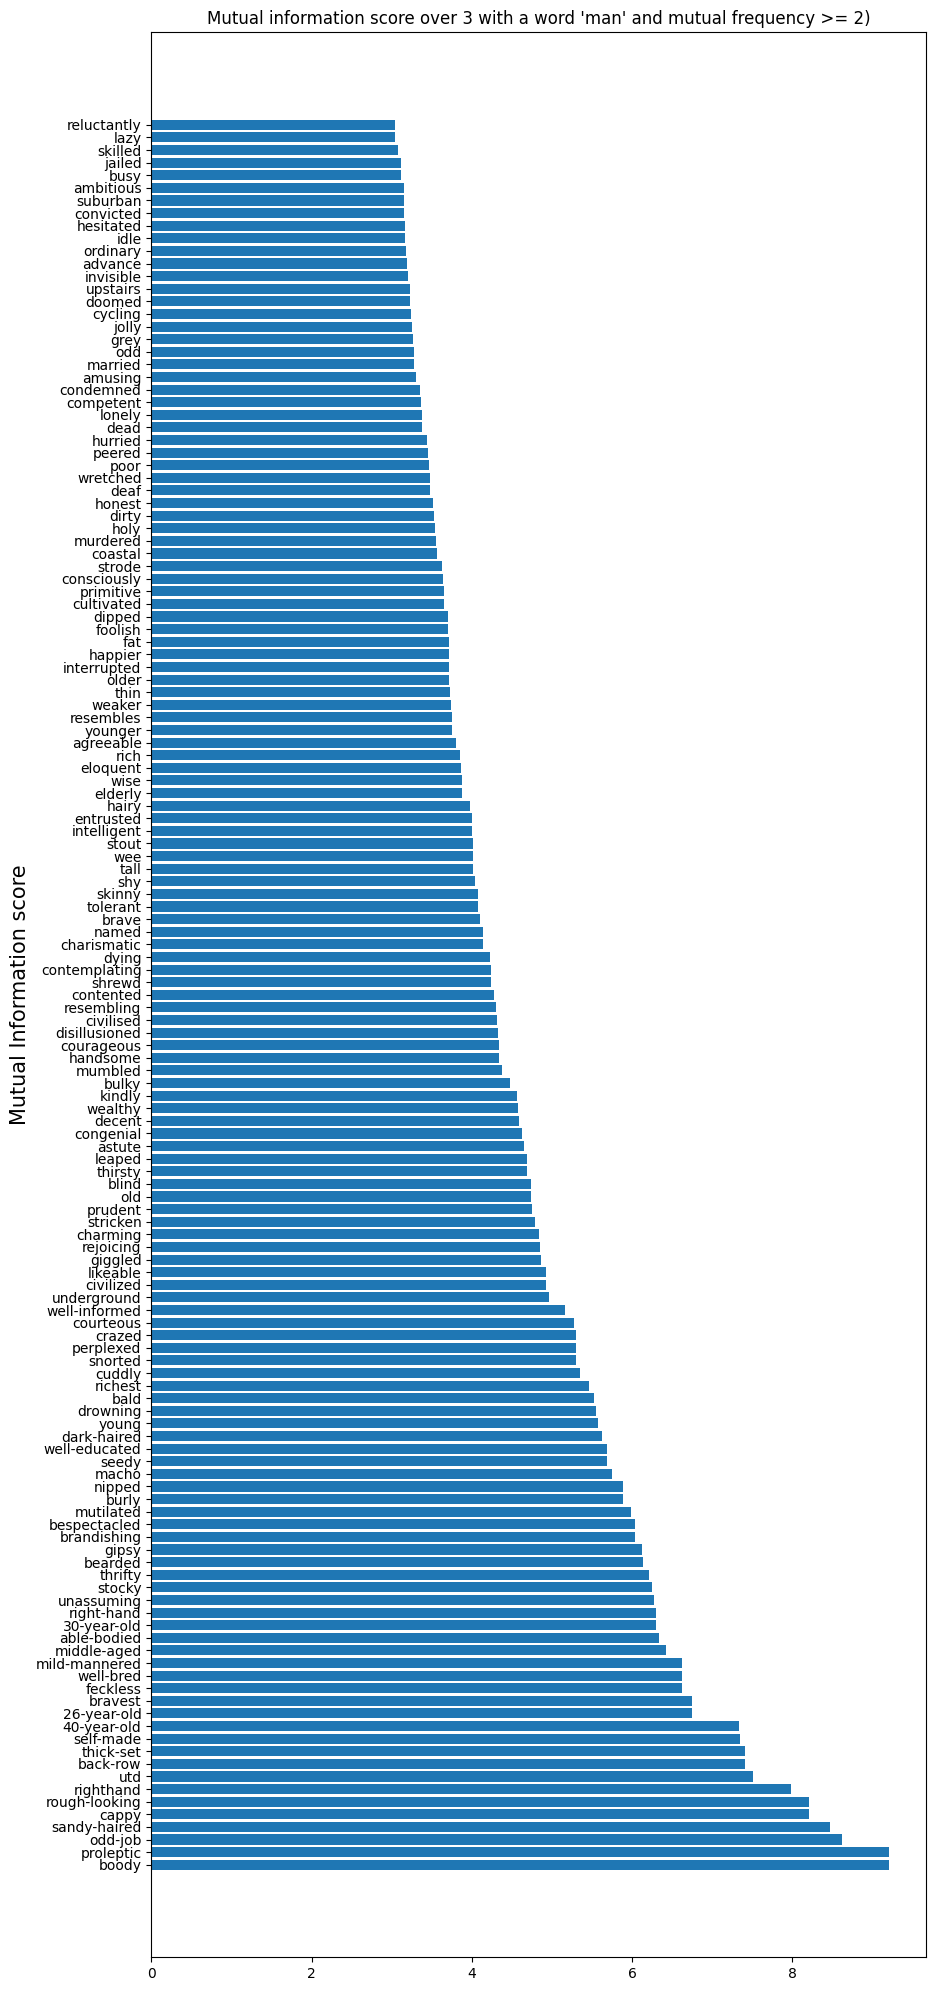

In [136]:
man.plotFrequencyFigure(10,25)
man.plotMiFigure(10,25)

Word of interest: sky
Frequncy in corpus: 743
Collocate words found: 13


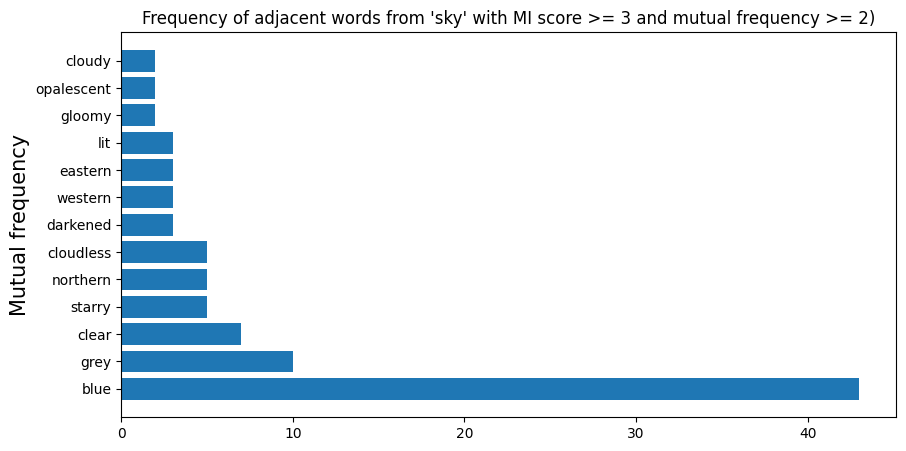

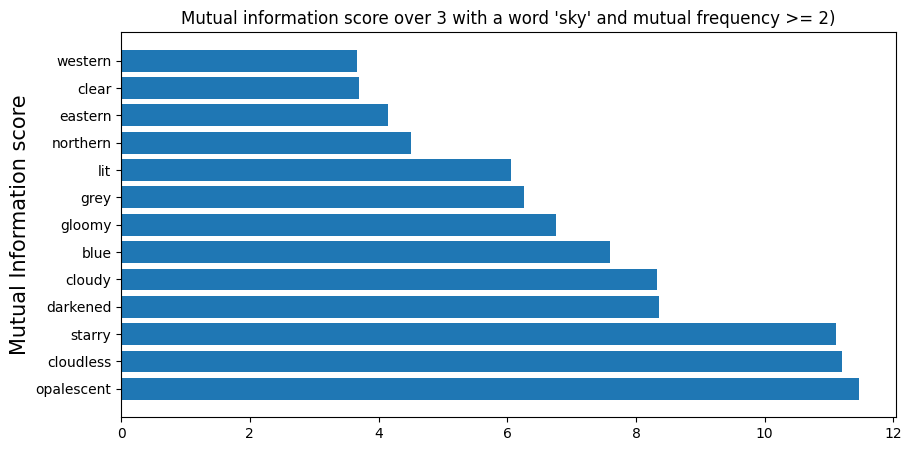

In [137]:
sky = MutualInformationCalculator('sky', sentences, lower_words, span, sizeOfCorpus, fdist)
sky.calculateAll()
sky.printMe()
sky.plotFrequencyFigure(10,5)
sky.plotMiFigure(10,5)

Word of interest: life
Frequncy in corpus: 9588
Collocate words found: 95


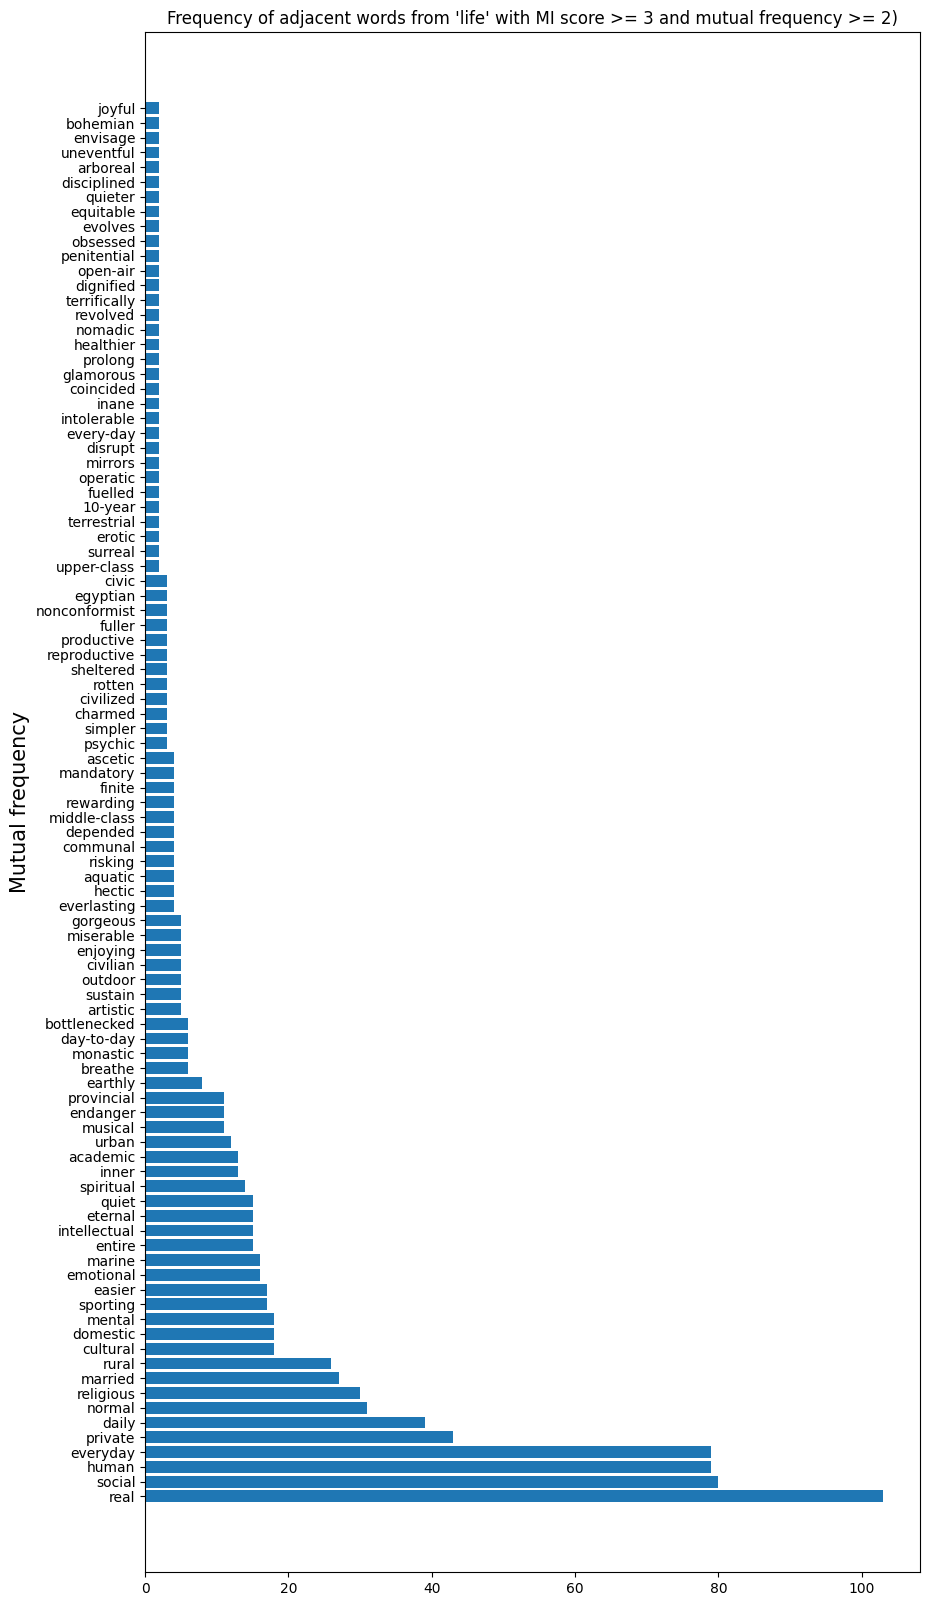

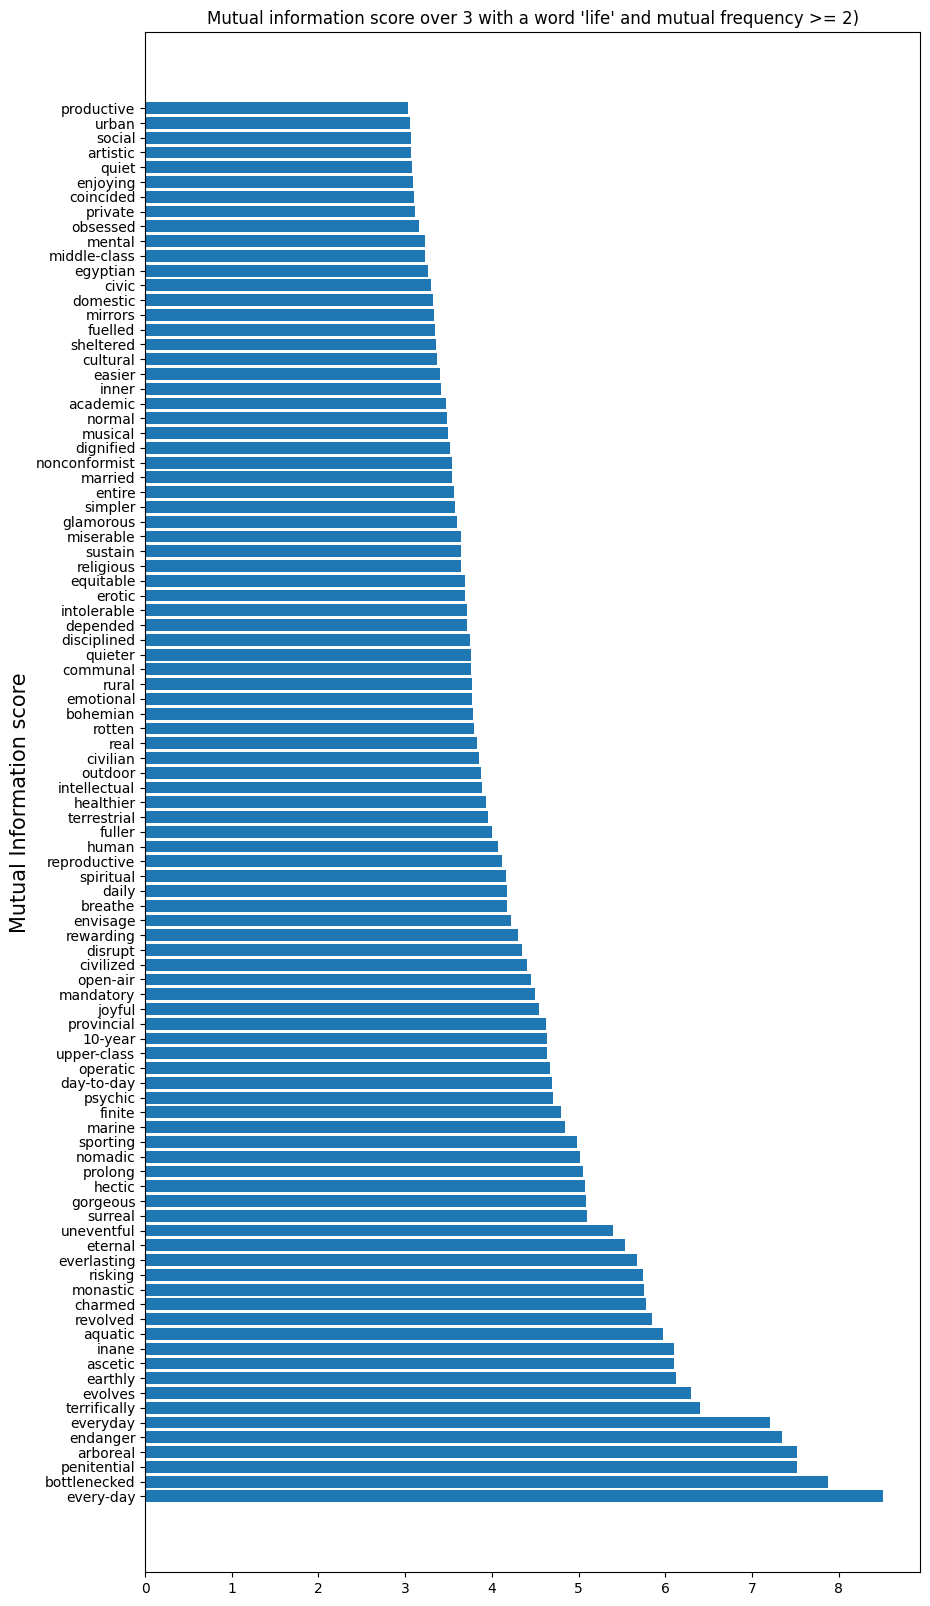

In [138]:
life = MutualInformationCalculator('life', sentences, lower_words, span, sizeOfCorpus, fdist)
life.calculateAll()
life.printMe()
life.plotFrequencyFigure(10,20)
life.plotMiFigure(10,20)

Word of interest: love
Frequncy in corpus: 3232
Collocate words found: 30


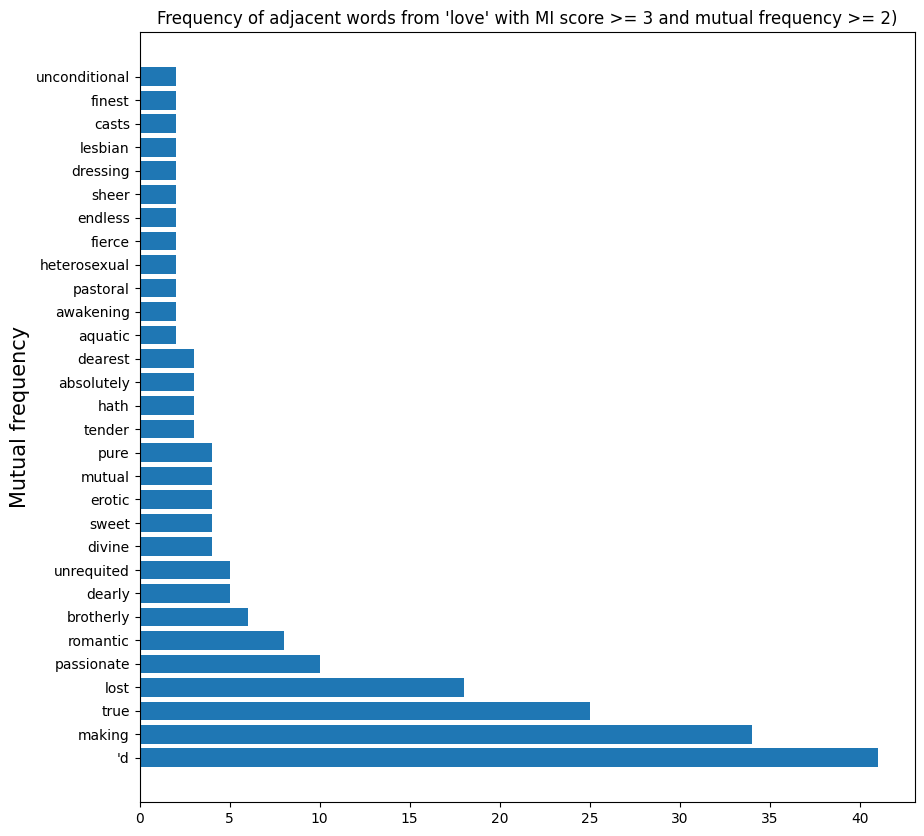

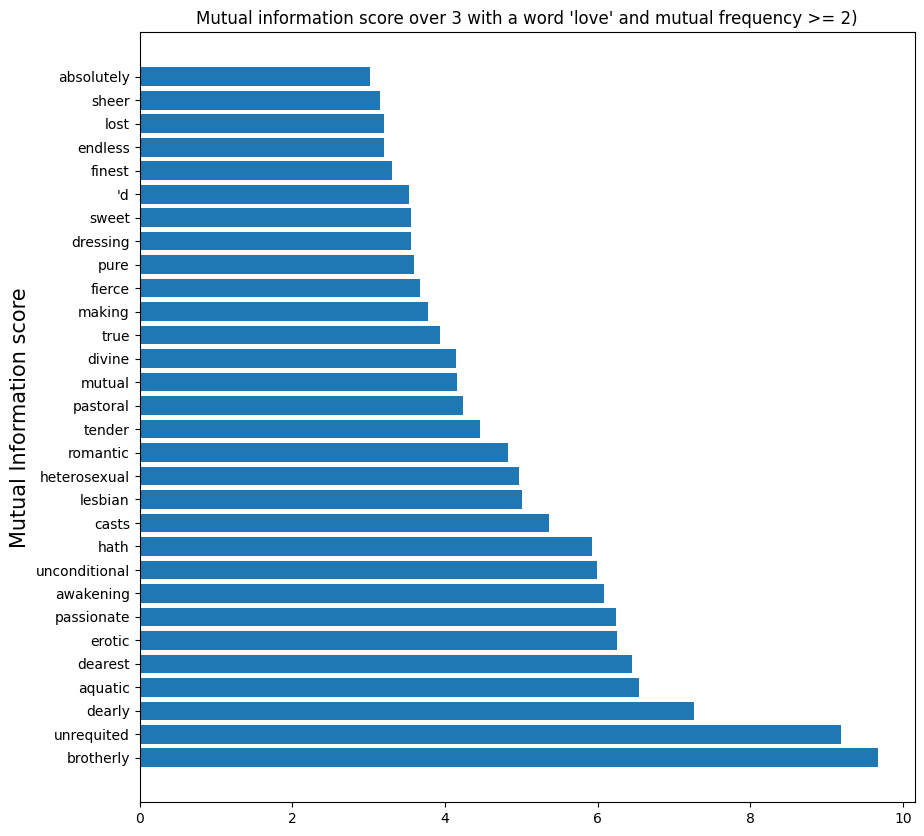

In [139]:
love = MutualInformationCalculator('love', sentences, lower_words, span, sizeOfCorpus, fdist)
love.calculateAll()
love.printMe()
love.plotFrequencyFigure(10,10)
love.plotMiFigure(10,10)

Word of interest: hate
Frequncy in corpus: 341
Collocate words found: 5


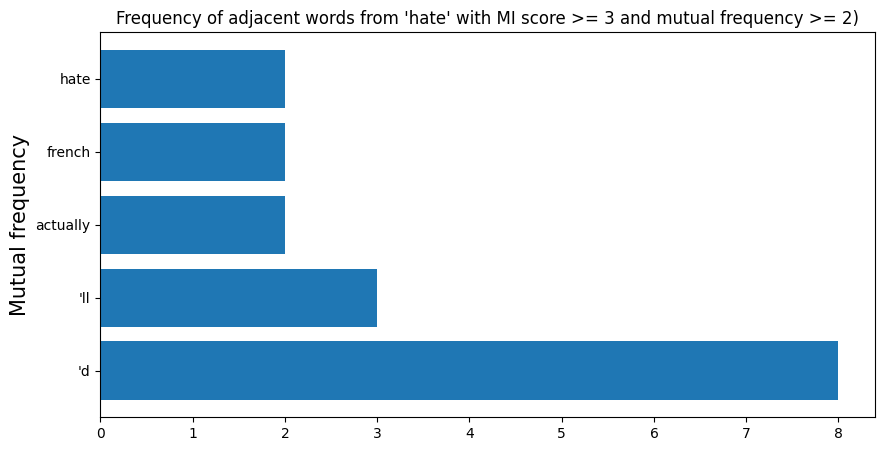

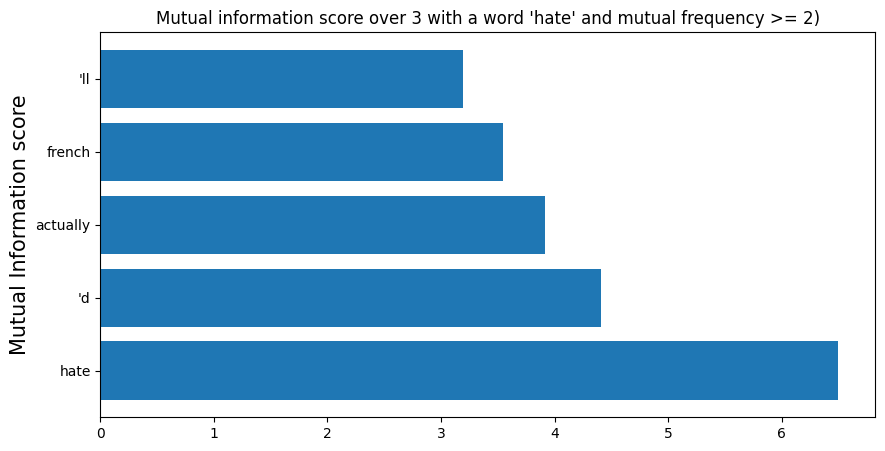

In [140]:
hate = MutualInformationCalculator('hate', sentences, lower_words, span, sizeOfCorpus, fdist)
hate.calculateAll()
hate.removeCollocatesBelowFrequency(2)
hate.removeCollocatesBelowMI(3)
hate.printMe()
hate.plotFrequencyFigure(10,5)
hate.plotMiFigure(10,5)